# The Multi-dimensional Knapsack Problem

### Kathmandu University

#### Department of Computer Science and Engineering

#### COMP472 - Artificial Intelligence

#### Student Name: Aayush Pokharel

#### Program: BSc Computer Science (2019)

#### Roll Number: 43


## Aquiring the problem data

- This function reads the data of a given problem instance
- It returns four variables in the the following order, using the variable names as in the mathematical formulation described in the coursework
  - _n_: number of items,
  - _m_: number of constraints
  - _p_: one dimensional numpy array with the profit coefficients fore ach item
  - _r_: two dimensional numpy array with the resource coefficients for each item on each constraint/resource
  - _b_: one dimensional numpy array with the constraints right-hand size, that is the bounds or capacities


# Multi-Dimensional KnapSack Problem Solver

This Python script aims to solve instances of the multi-dimensional knapsack problem using both traditional hill climbing and a modified version with simulated annealing characteristics. The code is designed to read problem instances from a text file, perform experiments, and visualize the results.


## Functionality Overview

**The overview listing the functionality of the code.**

0. Imports
1. Data Reading
2. Dataframe Creation
3. Solution Evaluation
4. Traditional Hill Climbing
5. Modified Hill Climbing (Simulated Annealing)
6. Experiment Execution
7. Results Plotting
8. Main Execution


# Code


### 0. Imports

All the libraries used in this assignment is imported here.


In [1]:
# Imports all the libraries needed for the project
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time

### 1. Data Reading

The `read_multi_knapsack` function reads the instance data from a text file and extracts the necessary parameters, including the number of items (`n`), the number of constraints (`m`), profits (`p`), resource coefficients (`r`), and resource capacities (`b`).


In [2]:
# Function given in the assignment that describes how the data is read
def read_multi_knapsack(fname):
    """
    Reads the data of a multi-knapsack instance

    :param fname: file name with instance data
    :return: n, m, p, r and b (as described above)
    """
    profits = []
    with open(fname, "r") as kfile:
        lines = kfile.readlines()

    # convert m, n to integer variables
    n, m = [int(d) for d in lines[0].split()]  # convert string data to integers

    input_line_cnt = 1  # input lines index after the first line
    p = np.empty(0, dtype=np.int64)
    while p.size < n:
        d = np.loadtxt(lines[input_line_cnt].split(), delimiter=" ", dtype=np.int64)
        p = np.append(p, d)
        input_line_cnt += 1

    r = np.empty((0, n), dtype=np.int64)
    for i in range(m):
        lin = np.empty(0, dtype=np.int64)
        while lin.size < n:
            d = np.loadtxt(lines[input_line_cnt].split(), delimiter=" ", dtype=np.int64)
            lin = np.append(lin, d)
            input_line_cnt += 1
        r = np.vstack((r, lin))

    # get the capacities (max of one line space-separated integer values)
    b = np.loadtxt(lines[input_line_cnt].split(), delimiter=" ", dtype=np.int64)

    return n, m, p, r, b

### 2. DataFrame Creation

The `create_dataframe` function constructs Pandas DataFrames for a clear representation of item profits and resource capacities. This function was used inplace of the provided function as displaying results in a dataframe makes it easier to visualize the input data.


In [3]:
def create_dataframe(n, m, profits, res, cap):
    """
    Creates Pandas DataFrames from the extracted data for better visualization and analysis.

    :param n: number of items
    :param m: number of constraints
    :param profits: array of profits for each item
    :param res: 2D array of resource usage for each item and each constraint
    :param cap: array of constraint capacities
    :return: two Pandas DataFrames for items and capacities
    """
    data = {"Item": [f"Item_{i+1}" for i in range(n)], "Profit": profits}
    for i in range(m):
        data[f"Resource_{i+1}_Usage"] = res[i]

    df_items = pd.DataFrame(data)

    data = {f"Resource_{i+1}_Capacity": [cap[i]] for i in range(m)}
    df_capacity = pd.DataFrame(data)

    return df_items, df_capacity

### 3. Solution Evaluation

The `evaluate_solution` function computes the total profit of a given solution, considering the profitability of each item and satisfying the capacity constraints. The `is_solution_valid` function checks if a solution adheres to the capacity constraints.


In [4]:
def evaluate_solution(solution, profits, resources, capacities):
    """
    Evaluates the profit of a given solution, taking into account resource constraints.

    :param solution: binary array representing the solution
    :param profits: array of profits for each item
    :param resources: 2D array of resource usage for each item and each constraint
    :param capacities: array of constraint capacities
    :return: total profit of the solution
    """
    total_profit = np.dot(solution, profits)
    resource_usage = np.dot(solution, np.transpose(resources))

    if any(resource_usage > capacities):
        return 0

    return total_profit

In [5]:
def is_solution_valid(solution, resources, capacities):
    """
    Checks if a solution is valid, i.e., it satisfies the resource constraints.

    :param solution: binary array representing the solution
    :param resources: 2D array of resource usage for each item and each constraint
    :param capacities: array of constraint capacities
    :return: True if the solution is valid, False otherwise
    """
    resource_usage = np.dot(solution, np.transpose(resources))
    return not any(resource_usage > capacities)

### 4. Traditional Hill Climbing

The `hill_climbing` function implements traditional hill climbing to find a locally optimal solution. It starts with a random solution and iteratively explores neighboring solutions, updating to the best-found solution.


In [6]:
def hill_climbing(profits, res, cap, max_iterations):
    """
    Hill-climbing algorithm to solve the multi-dimensional knapsack problem.

    :param profits: array of profits for each item
    :param res: 2D array of resource usage for each item and each constraint
    :param cap: array of constraint capacities
    :param max_iterations: maximum number of iterations
    :return: best solution and its corresponding profit
    """
    num_items = len(profits)
    best_solution = [random.randint(0, 1) for _ in range(num_items)]
    best_fitness = evaluate_solution(best_solution, profits, res, cap)

    for _ in range(max_iterations):
        neighbor_fitnesses = []
        neighbors = []

        for i in range(num_items):
            neighbor = best_solution.copy()
            neighbor[i] = 1 - neighbor[i]
            neighbors.append(neighbor)
            neighbor_fitness = evaluate_solution(neighbor, profits, res, cap)
            neighbor_fitnesses.append(neighbor_fitness)

        max_fitness_index = np.argmax(neighbor_fitnesses)
        max_fitness = neighbor_fitnesses[max_fitness_index]

        if max_fitness > best_fitness and is_solution_valid(
            neighbors[max_fitness_index], res, cap
        ):
            best_solution = neighbors[max_fitness_index]
            best_fitness = max_fitness

    return best_solution, best_fitness

### 5. Modified Hill Climbing (Simulated Annealing)

The `modified_hill_climbing` function introduces a modified hill climbing approach with simulated annealing. It incorporates probabilistic acceptance of worse solutions, controlled by a temperature parameter that decreases over time.

The modification allows for uphill moves with a certain probability, controlled by the temperature paramenter which helps to overcome local optima.


In [7]:
def modified_hill_climbing(
    profits, res, cap, max_iterations, temperature, cooling_rate
):
    """
    Modified hill-climbing algorithm with simulated annealing.

    :param profits: array of profits for each item
    :param res: 2D array of resource usage for each item and each constraint
    :param cap: array of constraint capacities
    :param max_iterations: maximum number of iterations
    :param temperature: initial temperature for simulated annealing
    :param cooling_rate: rate at which temperature decreases
    :return: best solution and its corresponding profit
    """
    num_items = len(profits)
    current_solution = [random.randint(0, 1) for _ in range(num_items)]
    current_fitness = evaluate_solution(current_solution, profits, res, cap)

    best_solution = current_solution.copy()
    best_fitness = current_fitness

    for iteration in range(max_iterations):
        neighbor = current_solution.copy()
        index_to_change = random.randint(0, num_items - 1)
        neighbor[index_to_change] = (
            1 - neighbor[index_to_change]
        )  # Flip 0 to 1 and vice versa

        neighbor_fitness = evaluate_solution(neighbor, profits, res, cap)

        if neighbor_fitness > current_fitness or (
            random.uniform(0, 1)
            < np.exp((neighbor_fitness - current_fitness) / temperature)
            and is_solution_valid(neighbor, res, cap)
        ):
            current_solution = neighbor
            current_fitness = neighbor_fitness

        if current_fitness > best_fitness:
            best_solution = current_solution
            best_fitness = current_fitness

        # Cool the temperature
        temperature *= cooling_rate

    return best_solution, best_fitness

##### **Search Operators/Components**

**Initial Solution :** The initial solution is generated randomly just like in the traditional hill-climbing algorithm.

**Fitness Evaluation :** The fitness evaluation in the `evaluate_solution` function calculates the total profit of a binary solution based on item profits, considering resource constraints. It efficiently computes the resource usage using dot products, checks for constraint violations, and returns either the total profit or 0 if constraints are violated, ensuring a comprehensive measure of solution quality in the multi-dimensional knapsack problem.

**Neighbour Generation :** A neighbor solution is generated by flipping the value of a randomly selected item in the current solution.

**Acceptance Criteria :** The new solution is accepted if it has a higher fitness than the current solution or with a certain probability determined by the simulated annealing criterion.

**Temperature Cooling :** The temperature is cooled at each iteration to control the probability of accepting worse solutions over time.

##### **Parameter Values and Justification**

**max_iterations :** This parameter determines the maximum number of iterations for the algorithm. It controls the runtime of the algorithm and influences the trade-off between exploration and exploitation.<br/>
A higher value allows more exploration. A value _(Here, used `1000`)_ that is higer allows the algorithm to explore the solution space extensively which leads to more chance of escaping local optima.

**temperature :** The initial temperature for simulated annealing. A higher initial temperature allows more exploration, as it increases the probability of accepting worse solutions.<br/>
A value _(Here, used `1`)_ that is higher allows for increase in proablility of accepting worse solution which promotes exploration in early stage of the algorithm.

**cooling_rate :** The rate at which the temperature decreases. A lower cooling rate allows the algorithm to explore more possibilities before converging. However, if it's too low, the algorithm may get stuck in local optima.<br/>
A value _(Here, used `0.99`)_ that is closure to 1 ensures a slower cooling process alowing algorithm to explore a larger solution space before converging which avoids premature convergence that leads to suboptimal solution.


### 6. Experiment Execution

The `run_experiments` and `run_modified_experiments` functions conduct multiple experiments with traditional and modified hill climbing, respectively, and collect the best solutions and profits.


In [8]:
def run_experiments(n_experiments, profits, res, cap, max_iterations):
    """
    Runs the hill-climbing algorithm multiple times to observe different solutions.

    :param n_experiments: number of experiments to run
    :param profits: array of profits for each item
    :param res: 2D array of resource usage for each item and each constraint
    :param cap: array of constraint capacities
    :return: list of best solutions and their corresponding profits
    """
    best_solutions = []
    best_profits = []

    for _ in range(n_experiments):
        best_solution, best_fitness = hill_climbing(profits, res, cap, max_iterations)
        best_solutions.append(best_solution)
        best_profits.append(best_fitness)

    return best_solutions, best_profits

In [9]:
def run_modified_experiments(
    n_experiments, profits, res, cap, max_iterations, temperature, cooling_rate
):
    """
    Runs the modified hill-climbing algorithm with simulated annealing.

    :param n_experiments: number of experiments to run
    :param profits: array of profits for each item
    :param res: 2D array of resource usage for each item and each constraint
    :param cap: array of constraint capacities
    :return: list of best solutions and their corresponding profits
    """
    best_solutions = []
    best_profits = []

    for _ in range(n_experiments):
        best_solution, best_fitness = modified_hill_climbing(
            profits, res, cap, max_iterations, temperature, cooling_rate
        )
        best_solutions.append(best_solution)
        best_profits.append(best_fitness)

    return best_solutions, best_profits

### 7. Results Plotting

The `plot_results` function generates a plot of the total profit versus the experiment number for visual analysis.


In [10]:
def plot_results(best_profits):
    """
    Plots the results to visualize the total profit achieved in each experiment.

    :param best_profits: list of total profits from different experiments
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(best_profits) + 1), best_profits, marker="o", linestyle="-")
    plt.xlabel("Experiment Number")
    plt.ylabel("Total Profit")
    plt.title("Total Profit vs. Experiment Number")
    plt.grid(True)
    plt.show()

### 8. Main Execution

The `main` function orchestrates the entire process. It reads the data, performs experiments with traditional and modified hill climbing, prints and visualizes the results, and compares the two approaches.

**_Note: The `main` function is created to check the working of the code and see if it is performing as expected. The performace Comparision requred for assignment is in a different cell._**


n: 28.  m: 2

Items DataFrame:
       Item  Profit  Resource_1_Usage  Resource_2_Usage
0    Item_1    1898                45                30
1    Item_2     440                 0                20
2    Item_3   22507                85               125
3    Item_4     270               150                 5
4    Item_5   14148                65                80
5    Item_6    3100                95                25
6    Item_7    4650                30                35
7    Item_8   30800                 0                73
8    Item_9     615               170                12
9   Item_10    4975                 0                15
10  Item_11    1160                40                15
11  Item_12    4225                25                40
12  Item_13     510                20                 5
13  Item_14   11880                 0                10
14  Item_15     479                 0                10
15  Item_16     440                25                12
16  Item_17     4

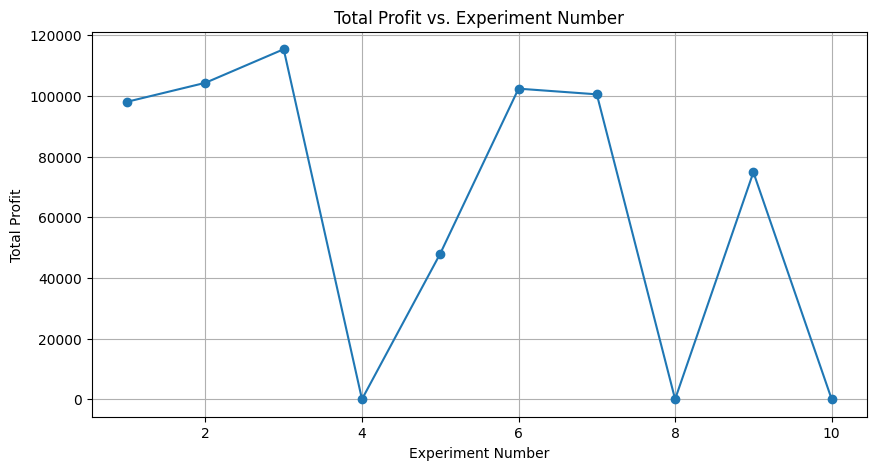


Results from Multiple Experiments(Modified):
Experiment 1 - Profit: 59337, Solution: [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
Experiment 2 - Profit: 73910, Solution: [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
Experiment 3 - Profit: 87447, Solution: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
Experiment 4 - Profit: 0, Solution: [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]
Experiment 5 - Profit: 67621, Solution: [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1]
Experiment 6 - Profit: 0, Solution: [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
Experiment 7 - Profit: 83685, Solution: [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
Experiment 8 - Profit: 0, Solution: [1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,

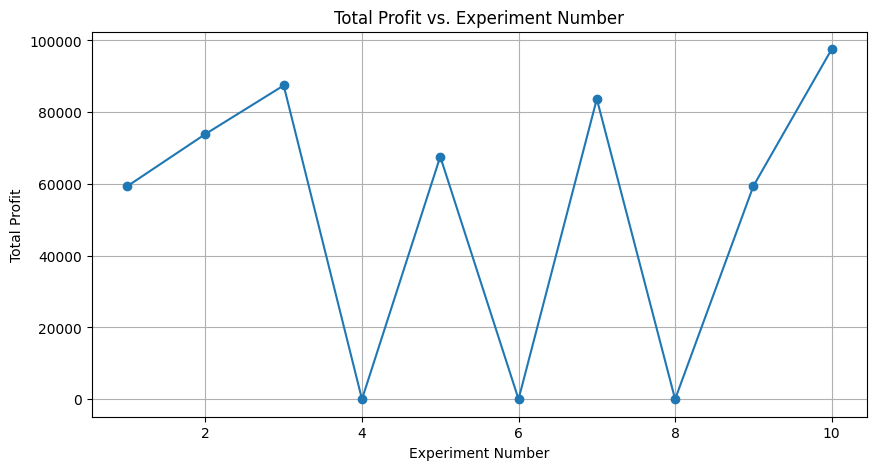

In [11]:
def main(dataset_file_name):
    """
    Main function to execute the entire process, from reading the dataset to running experiments and visualizing results.

    :param dataset_file_name: name of the dataset file
    """
    n, m, profits, res, cap = read_multi_knapsack(dataset_file_name)

    df_items, df_capacity = create_dataframe(n, m, profits, res, cap)

    num_experiments = 10

    best_solutions, best_profits = run_experiments(
        num_experiments, profits, res, cap, max_iterations=1000
    )
    best_solutions_mod, best_profits_mod = run_modified_experiments(
        num_experiments,
        profits,
        res,
        cap,
        max_iterations=1000,
        temperature=1.0,
        cooling_rate=0.995,
    )

    print(f"n: {n}.  m: {m}")
    print("\nItems DataFrame:")
    print(df_items)
    print("\nCapacity DataFrame:")
    print(df_capacity)

    print("\nResults from Multiple Experiments:")
    for i, (solution, profit) in enumerate(zip(best_solutions, best_profits), 1):
        print(f"Experiment {i} - Profit: {profit}, Solution: {solution}")

    plot_results(best_profits)

    print("\nResults from Multiple Experiments(Modified):")
    for i, (solution, profit) in enumerate(
        zip(best_solutions_mod, best_profits_mod), 1
    ):
        print(f"Experiment {i} - Profit: {profit}, Solution: {solution}")

    plot_results(best_profits_mod)


if __name__ == "__main__":
    main("multi_knap_n28_m2.txt")

## Performance Comparison


### Justification of Design

#### Version 1

The first version maintains the original hyperparameter values used in the modified hill-climbing algorithm above. These values are chosen for their balance between exploration and exploitation, providing a reasonable trade-off for the algorithm to explore the solution space adequately and converge to a good solution.<br/>
The values are:

- `max_iteration=1000`
- `temperature=1.0`
- `cooling_rate=0.0995`

##### Version 2

In the second version, the hyperparameters are adjusted to allow for slightly more exploration. The higher `initial_temperature` provide the algorithm with additional opportunities to explore a larger solution space, potentially discovering more diverse solutions.
The values are:

- `max_iteration=1000`
- `temperature=1.5`
- `cooling_rate=0.0995`

### Justification of Fair Comparison

- Both versions are run for at least **10 iterations** to account for the stochastic nature of the optimization method.
- The computational effort (running time) for both versions is the **same**, achieved by adjusting the `max_iterations` parameter. _(Here, used `1000` )_


In [12]:
def compare_algorithm_versions(n_runs, profits, res, cap):
    results_v1 = []
    results_v2 = []

    start_time = time.time()
    best_solutions, best_profits = run_modified_experiments(
        n_runs,
        profits,
        res,
        cap,
        max_iterations=1000,
        temperature=1.0,
        cooling_rate=0.995,
    )
    end_time = time.time()
    results_v1.append((best_solutions, best_profits, end_time - start_time))

    start_time = time.time()
    best_solutions, best_profits = run_modified_experiments(
        n_runs,
        profits,
        res,
        cap,
        max_iterations=1000,
        temperature=1.5,
        cooling_rate=0.995,
    )
    end_time = time.time()
    results_v2.append((best_solutions, best_profits, end_time - start_time))

    return results_v1, results_v2

In [13]:
def plot_results_comparison(best_profits_v1, best_profits_v2):
    """
    Plots the results to visualize the total profit achieved in each experiment.

    :param best_profits: list of total profits from different experiments
    """
    plt.plot(
        range(1, len(best_profits_v1) + 1), best_profits_v1, marker="o", linestyle="-"
    )
    plt.plot(
        range(1, len(best_profits_v2) + 1), best_profits_v2, marker="x", linestyle="-"
    )
    plt.xlabel("Experiment Number")
    plt.ylabel("Total Profit")
    plt.title("Total Profit vs. Experiment Number")
    plt.grid(True)


Results from Multiple Experiments (Version 1):
Experiment 1 - Profit: 0, Solution: [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
Experiment 2 - Profit: 7134, Solution: [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,

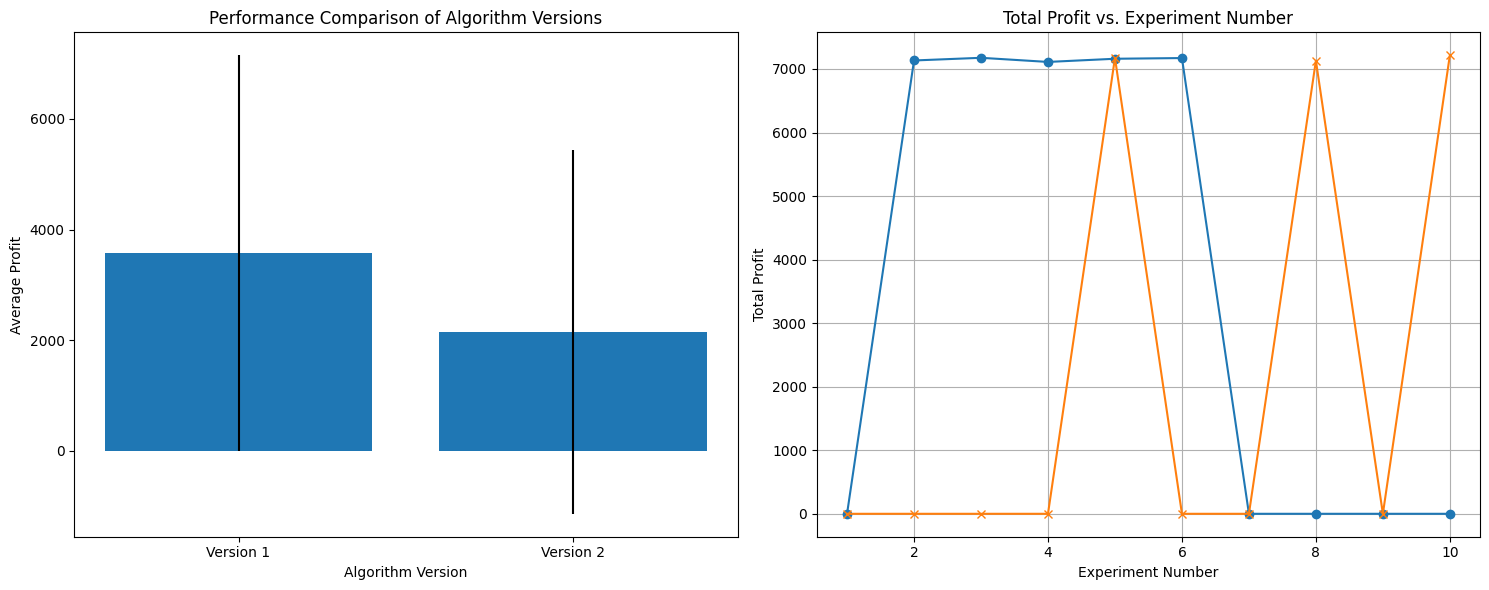

In [14]:
def run_comparison(dataset_file_name, n_runs=10):
    n, m, profits, res, cap = read_multi_knapsack(dataset_file_name)
    results_v1, results_v2 = compare_algorithm_versions(n_runs, profits, res, cap)

    # print(results_v1)

    # Extract and print the average and standard deviation for each version
    avg_v1 = np.mean(results_v1[0][1])
    std_v1 = np.std(results_v1[0][1])

    avg_v2 = np.mean(results_v2[0][1])
    std_v2 = np.std(results_v2[0][1])

    print("\nResults from Multiple Experiments (Version 1):")
    for i, (solution, profit) in enumerate(zip(results_v1[0][0], results_v1[0][1]), 1):
        print(f"Experiment {i} - Profit: {profit}, Solution: {solution}")

    print("Average Profit: {:.2f}\nStandard Deviation: {:.2f}".format(avg_v1, std_v1))
    print("The runtime of version 1 is {}".format(results_v1[0][2]))

    print("\nResults from Multiple Experiments (Version 2):")
    for i, (solution, profit) in enumerate(zip(results_v2[0][0], results_v2[0][1]), 1):
        print(f"Experiment {i} - Profit: {profit}, Solution: {solution}")

    print("Average Profit: {:.2f}\nStandard Deviation: {:.2f}".format(avg_v2, std_v2))
    print("The runtime of version 2 is {}".format(results_v2[0][2]))

    # Plot the results in a side-by-side bar plot
    plt.figure(figsize=(15, 6))

    # Plot for Performance Comparison
    plt.subplot(1, 2, 1)
    plt.bar(
        [1, 2],
        [avg_v1, avg_v2],
        yerr=[std_v1, std_v2],
        tick_label=["Version 1", "Version 2"],
    )
    plt.title("Performance Comparison of Algorithm Versions")
    plt.xlabel("Algorithm Version")
    plt.ylabel("Average Profit")

    # Plot for Profit vs. iteration
    plt.subplot(1, 2, 2)
    plot_results_comparison(results_v1[0][1], results_v2[0][1])
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()


if __name__ == "__main__":
    run_comparison("multi_knap_n200_m25.txt")